## Modélisation 

In [ ]:
!pip install import-ipynb
!pip install seaborn

In [2]:
# Données 
import import_ipynb
import declarations_AV as dec
import Recuperation_des_donnees_AV as donnees
import Carte_ensoleillement_AV as sol

In [25]:
# Modélisation
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics


Le but de cette partie est de prédire la consommation d'électricité par habitants à partir des données météo que nous avons récoltées.

### 1- Création d'un dataset alliant les données de consommation, températures et ensoleillement récupérées

Avant de commencer la modélisation, il est nécessaire de rassembler toutes les données collectées que nous utiliserons dans la modélisation dans un même DataFrame. Nous nous intéressons en particulier à l'année 2020.

In [4]:
df_2020=donnees.dico_df_cons_tot[2020].merge(donnees.dico_df_temp[2020], how='left', left_on='Code Département', right_on='code_insee_departement')
df_2020=df_2020.merge(sol.ensoleillement, how='left', left_on='Libellé Département', right_on='Départements')
df_2020=df_2020.drop(['code_insee_departement', 'departement','Départements'], axis='columns')
df_2020['tmoy']=round(df_2020['tmoy'],3)
#df_2020['Delta tempérarure']=df_2020['tmax']-df_2020['tmin']
df_2020.head(3)

,Code Département,Libellé Département,Consommation Résidentiel (MWh),Population,Consommation Résidentiel par habitant (MWh),tmoy,tmax,tmin,Temps d'ensoleillement (jours/an)
0,01,Ain,1.805527e+06,657856,2.745,12.769,38.9,-5.3,182.0
1,02,Aisne,1.281305e+06,529374,2.420,12.190,37.9,-4.7,142.0
2,03,Allier,8.808159e+05,335628,2.624,13.043,40.2,-6.3,161.0


In [5]:
print("NaN occurrences in Columns:")
print(df_2020.isnull().sum(axis=0))

NaN occurrences in Columns:
Code Département                               0
Libellé Département                            0
Consommation Résidentiel  (MWh)                0
Population                                     0
Consommation Résidentiel par habitant (MWh)    0
tmoy                                           0
tmax                                           0
tmin                                           0
Temps d'ensoleillement (jours/an)              4
dtype: int64


In [6]:
# On supprime les départements pour lesquels on a des valeurs d'ensoleillement manquantes
df_2020=df_2020.dropna(how='any')
df_2020.shape

(92, 9)

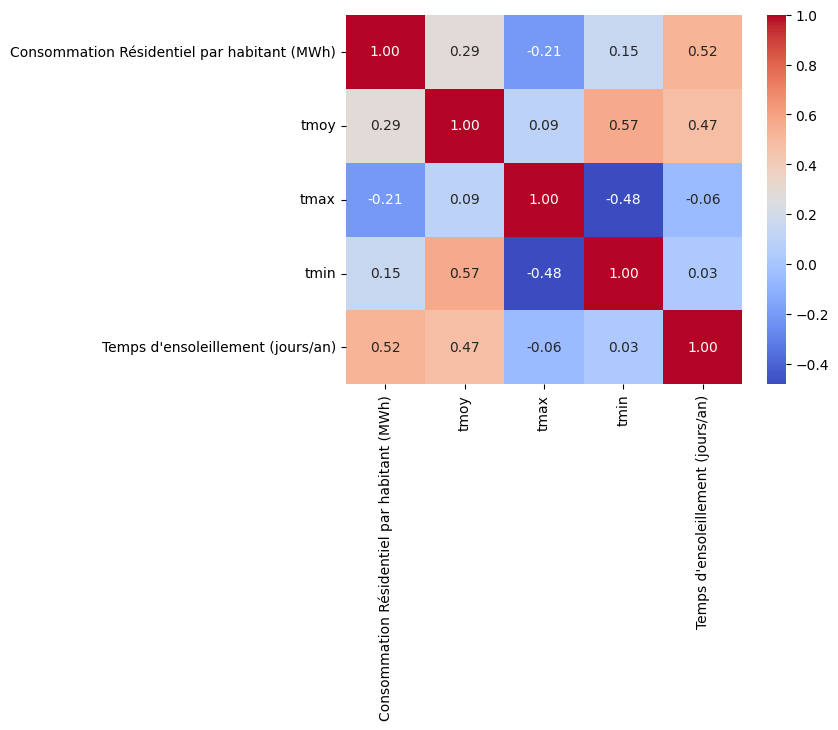

In [7]:
# Matrice de corrélation graphique
g1 = sns.heatmap(df_2020.drop(['Code Département','Libellé Département','Consommation Résidentiel  (MWh)',
                               'Population'], axis = 1).corr(), cmap='coolwarm', annot=True, fmt=".2f")

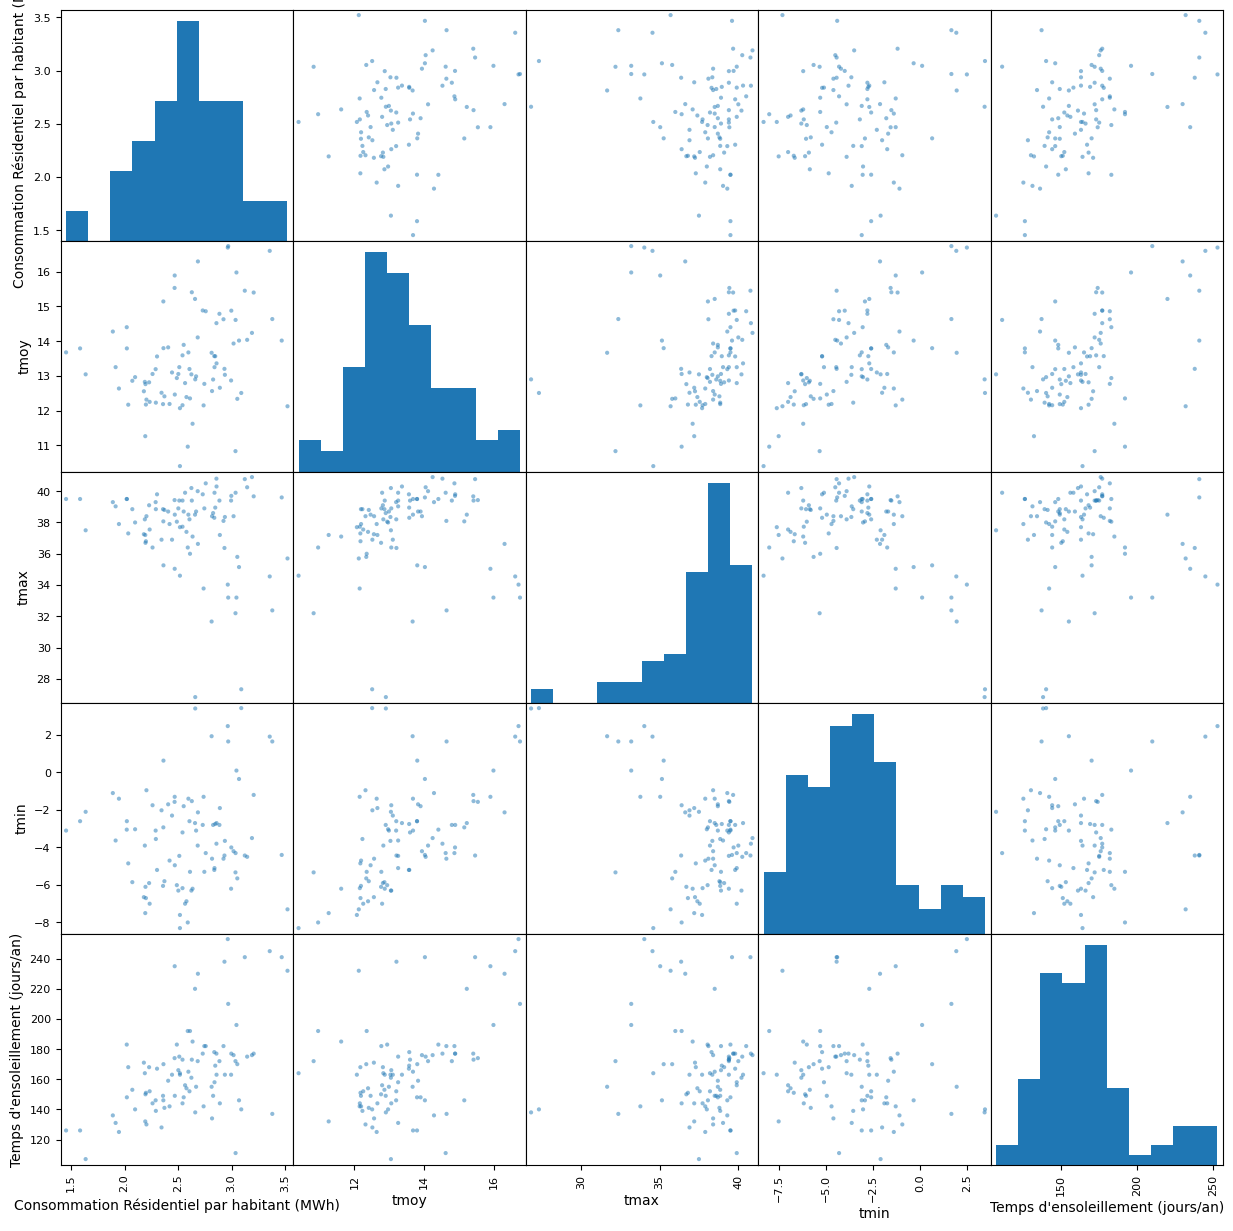

In [8]:
ax = pd.plotting.scatter_matrix(df_2020.drop(['Code Département','Libellé Département','Consommation Résidentiel  (MWh)',
                               'Population'], axis = 1), figsize = (15,15))

In [9]:
# Création d'une variable catégorielle pour les différentes températures moyennes
print(min(df_2020['tmoy']),max(df_2020['tmoy']))
df_2020['Catégories Températures']=pd.cut(df_2020['tmoy'],bins=3, labels=['Basse Température', 'Moyenne Température','Haute Température'])
df_2020.head(3)

10.4 16.739


,Code Département,Libellé Département,Consommation Résidentiel (MWh),Population,Consommation Résidentiel par habitant (MWh),tmoy,tmax,tmin,Temps d'ensoleillement (jours/an),Catégories Températures
0,01,Ain,1.805527e+06,657856,2.745,12.769,38.9,-5.3,182.0,Moyenne Température
1,02,Aisne,1.281305e+06,529374,2.420,12.190,37.9,-4.7,142.0,Basse Température
2,03,Allier,8.808159e+05,335628,2.624,13.043,40.2,-6.3,161.0,Moyenne Température


In [10]:
# Création de dummies pour deux des catégories de température
df_2020['Basse Température']=1*(df_2020['Catégories Températures']=='Basse Température')
df_2020['Haute Température']=1*(df_2020['Catégories Températures']=='Haute Température')
df_2020['Moyenne Température']=1*(df_2020['Catégories Températures']=='Moyenne Température')
df_2020.head(3)

,Code Département,Libellé Département,Consommation Résidentiel (MWh),Population,Consommation Résidentiel par habitant (MWh),tmoy,tmax,tmin,Temps d'ensoleillement (jours/an),Catégories Températures,Basse Température,Haute Température,Moyenne Température
0,01,Ain,1.805527e+06,657856,2.745,12.769,38.9,-5.3,182.0,Moyenne Température,0,0,1
1,02,Aisne,1.281305e+06,529374,2.420,12.190,37.9,-4.7,142.0,Basse Température,1,0,0
2,03,Allier,8.808159e+05,335628,2.624,13.043,40.2,-6.3,161.0,Moyenne Température,0,0,1


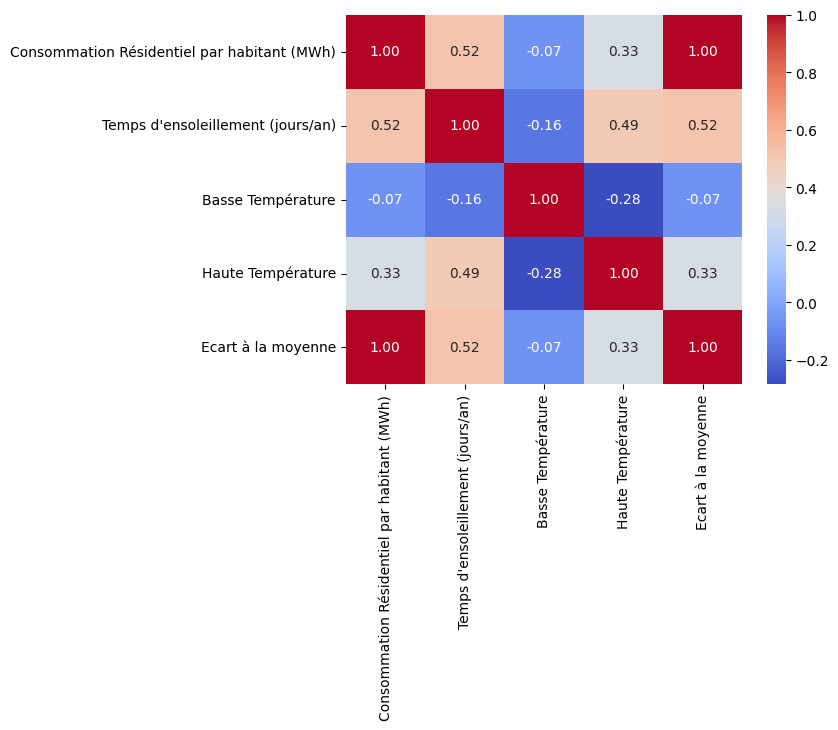

In [37]:
# Que donne la matrice des corrélations graphiques dans ce cas ?
# Matrice de corrélation graphique
g1 = sns.heatmap(df_2020.drop(['Code Département','Libellé Département','Consommation Résidentiel  (MWh)',
                               'Population','tmoy','Catégories Températures','tmin','tmax','Moyenne Température'], axis = 1).corr(), cmap='coolwarm', annot=True, fmt=".2f")

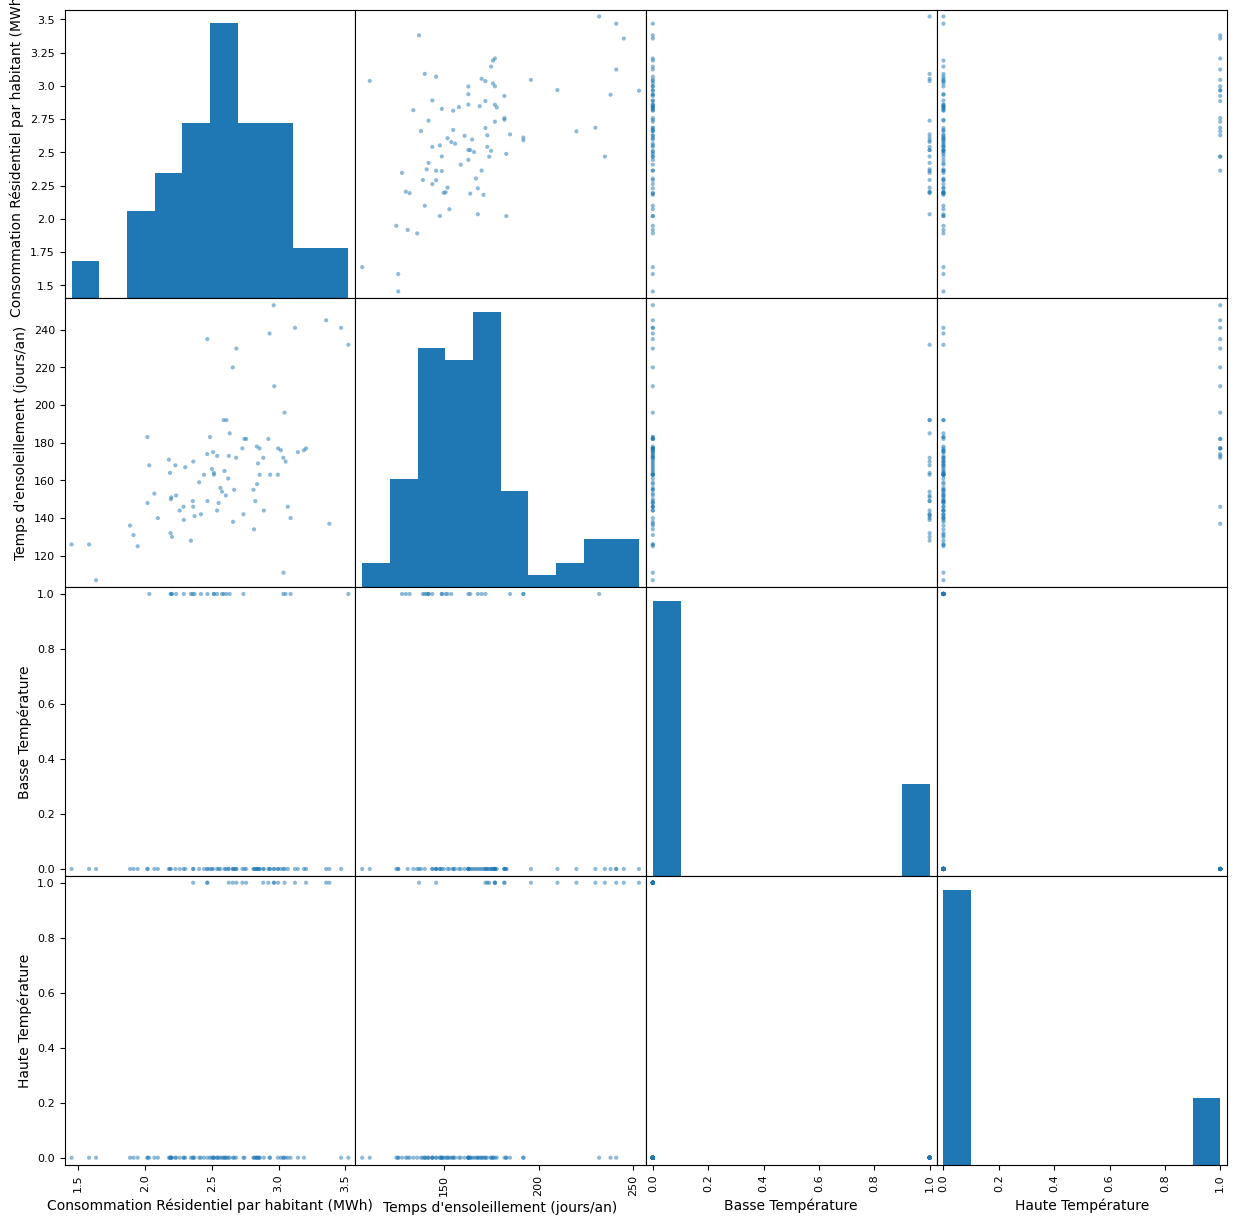

In [12]:
ax = pd.plotting.scatter_matrix(df_2020.drop(['Code Département','Libellé Département','Consommation Résidentiel  (MWh)',
                               'Population','tmoy','Catégories Températures','tmin','tmax','Moyenne Température'], axis = 1), figsize = (15,15))

Les représentations ci-dessus laissent penser qu'il y aurait une corrélation positive entre ensoleillement et consommation d'électricité. De plus, nous avons créé des variables de niveau pour la température moyenne, afin d'essayer de mieux capturer les effets de la température sur la consommation d'électricité. Il semble apparaître alors, que une augmentation du nombre de départements avec de hautes températures moyennes serait associée à une augmentation de la consommation d'électricité.\
Bien que nous ayons des tables de données pour plusieurs années, nous préferons ne pas les agréger. En effet, la consommation d'électricité pourrait être en niveau spécifique à une année, d'autant plus que les années pour lesquelles nous possédons des données de consommation et de températures sont de 2018 à 2020 (incluant donc le début de la période Covid).\
Etant donné notre nombre restreint de données, il va sûrement être difficile d'obtenir par la suite un modèle économétrique de prédiction satisfaisant. 

In [26]:
# Une première régression linéaire multiple
X=df_2020[["Temps d'ensoleillement (jours/an)","Haute Température","Basse Température"]]
Y=df_2020["Consommation Résidentiel par habitant (MWh)"]
lm.fit(X,Y)


NameError: name 'lm' is not defined

In [16]:
# Régression linéaire de la consommation d'électricité du résidentiel par habitant sur les variables météorologiques
x_vars=["Temps d'ensoleillement (jours/an)","Haute Température","Basse Température"]

df_reg=df_2020[['Consommation Résidentiel par habitant (MWh)']+x_vars].copy()
X_train, X_test, y_train, y_test = train_test_split(df_reg.drop(['Consommation Résidentiel par habitant (MWh)'],axis='columns'),
                                                    df_reg['Consommation Résidentiel par habitant (MWh)'],
                                                    test_size=0.1, random_state=123)
ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

In [17]:
#2. Afficher les valeurs des coefficients
print(ols.intercept_, ols.coef_)

1.840662697236176 [ 0.00445941  0.14353528 -0.0369206 ]


In [18]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
rsq = sklearn.metrics.r2_score(y_test, y_pred) 

print('Mean squared error: %.2f'
      % rmse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % rsq)

Mean squared error: 0.41
Coefficient of determination: 0.52


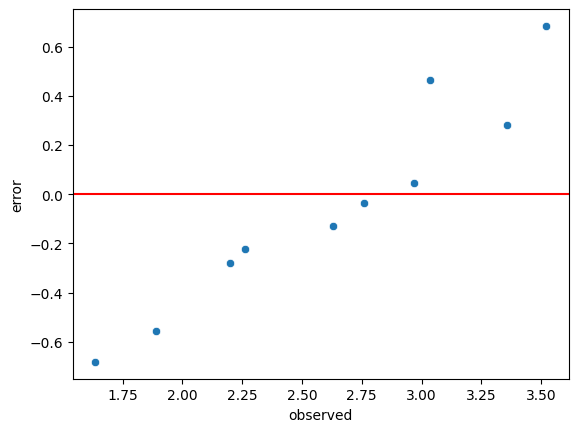

In [21]:
#4. Nuage de points des valeurs observées
tempdf = pd.DataFrame({"prediction": y_pred, "observed": y_test,
                       "error": y_test - y_pred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "error")
g.axhline(0, color = "red")

# La répartition des erreurs n'est clairement pas 
# aléatoire en fonction de $X$.
# Le modèle souffre
# donc d'un problème de spécification. 

In [39]:
# Tentative d'amélioration du modèle : on considère plutôt la variable d'écart à la moyenne de la consommation
# d'électricité par habitant
df_2020['Ecart à la moyenne']=df_2020['Consommation Résidentiel par habitant (MWh)']-df_2020['Consommation Résidentiel par habitant (MWh)'].mean()
df_reg2=df_2020[["Ecart à la moyenne","Haute Température","Basse Température","Temps d'ensoleillement (jours/an)"]].copy()

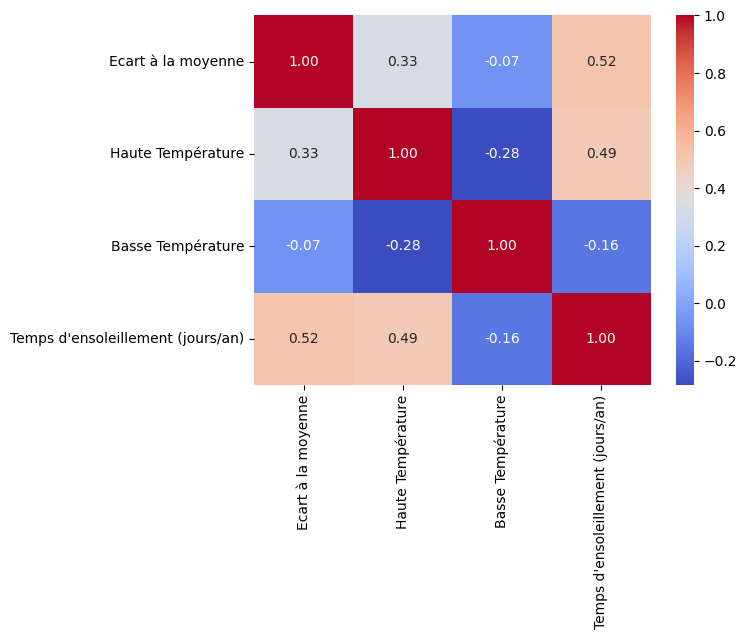

In [34]:
g2 = sns.heatmap(df_reg2.corr(), cmap='coolwarm', annot=True, fmt=".2f")

In [ ]:
ax2= pd.plotting.scatter_matrix(df_reg2, figsize = (15,15))

In [45]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_reg2.drop(['Ecart à la moyenne'], axis='columns'),
                                                    df_reg2['Ecart à la moyenne'],
                                                    test_size=0.1)
ols2 = LinearRegression().fit(X_train2, y_train2)
y_pred2 = ols2.predict(X_test2)
print(ols2.intercept_, ols2.coef_)

-1.0929730811475307 [0.13404055 0.00435775 0.00647241]


In [46]:
rmse2 = sklearn.metrics.mean_squared_error(y_test2, y_pred2, squared = False)
rsq2 = sklearn.metrics.r2_score(y_test2, y_pred2) 

print('Mean squared error: %.2f'
      % rmse2)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % rsq2)

Mean squared error: 0.26
Coefficient of determination: 0.46
